# "Cricket vs Baseball"
> "Deep Neural network attempts to distinguish between whether someone is playing baseball or cricket"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Krishnan Srinivasarengan
- categories: [projects]

This is a deep learning trained model that attempts to distinguish between cricket and baseball players

The result will be either of: Batsman (cricket) Bowler (cricket) Batter (baseball) Pitcher (baseball).

The model was trained using image search data from Bing. However, the data was quite bad (with a lot of cartoons and unrelated images) and hence the classifier is not very good. For example, the stumps in a cricketer's image is primarily attributed to a batsman and if stumps appears in a bowler's image, it is likely to be classified as batsman.

This is the reason why I moved to handling another problem, [Feling Classifier](https://krishnans14.github.io/feedback-control/projects/2020/12/01/Feline-Classifier.html). That blog entry details the step-by-step discussion on how the neural network classifier was developed using Fastai, PyTorch and Bing Image search

In this blog entry, a very brief description of the steps that went into building this model is given, espcially to both show how we collected the images as well as the reason why this wasn't much successful by showing examples of the training data. The steps are cursory and some outputs (such as training) are not shown here (I was trying to reduce the size of the jupyter notebook and instead ended up removing all outputs).

Even then, the app was built and is hosted on binder here: 
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/krishnans14/Cricket_vs_Baseball/main?urlpath=voila%2Frender%2Fcricball_classifier_app.ipynb)

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Acquiring Images using Bing Search

In [ ]:
key = 'xxpas324sc4r3r32'  # This is not the actual key, but something random to hide my key

To ensure that the images are as relevant as possible, I used a search term with the name of the sport prefixed to it. This means, I had to use a different image folder name.

In [ ]:
image_types = 'cricket batsman','cricket bowler','baseball batter', 'baseball pitcher'
image_folder_names = 'batsman', 'bowler', 'batter', 'pitcher'
path = Path('cricball')

In [ ]:
if not path.exists():
    path.mkdir()
    for type,foldername in zip(image_types,image_folder_names):
        dest = (path/foldername)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{type}')
        download_images(dest, urls=results.attrgot('content_url'))

And remove any corrupted images

In [ ]:
fns = get_image_files(path)
failed = verify_images(fns)

failed.map(Path.unlink);

In [ ]:
sportsmen = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = sportsmen.dataloaders(path)

In [ ]:
sportsmen = sportsmen.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = sportsmen.dataloaders(path)
dls.valid.show_batch(max_n=12, nrows=2)

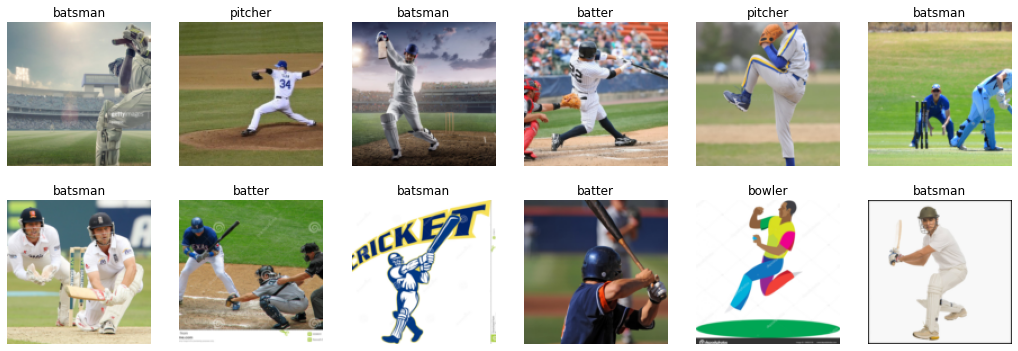

Already we see some ridiculous set of images. But we move on and wait for the first training to help us with correcting data errors.

## Training the Model to pick the bad ones

In [ ]:
sportsmen = sportsmen.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = sportsmen.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

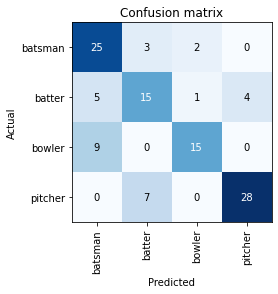

In [ ]:
interp.plot_top_losses(18, nrows=3)

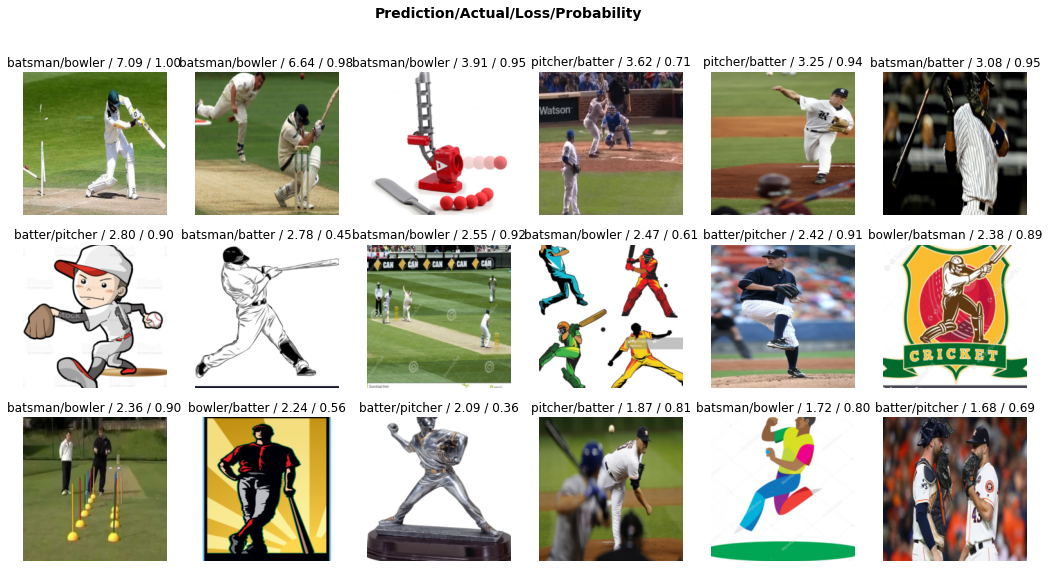

Honestly, this is disappointingly bad set of data. So many cartoons and sketches, and even some completely irrelevant images. So we clean these up a bit.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Unfortunately, the widget is not showing up above, but well, you can refer to how it looks in the [Feline Classifier](https://krishnans14.github.io/feedback-control/projects/2020/12/01/Feline-Classifier.html) blog entry.

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Running the traning again

In [ ]:
sportsmen = sportsmen.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = sportsmen.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

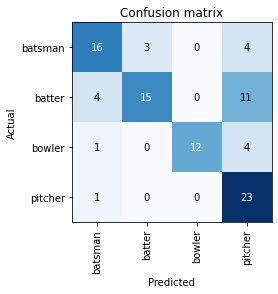

In [ ]:
interp.plot_top_losses(18, nrows=3)

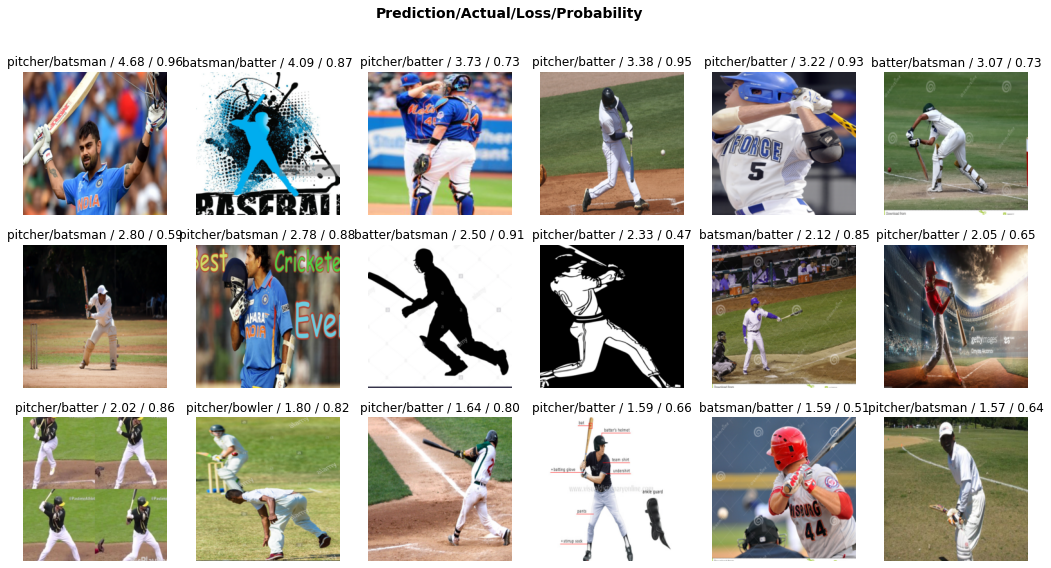

Slightly better, but the mismatch in the prediction says that NN is struggling in its task. We do some more cleaning

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Some more cleanup

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
sportsmen = sportsmen.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = sportsmen.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

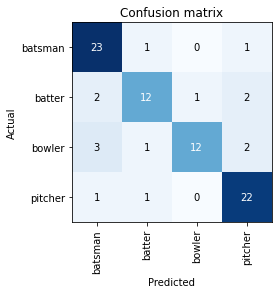

The confusion matrix seems okay here. And we say we will stop this whole thing here.

So we just export the model and live with it

In [ ]:
learn.export()

## The Final App

The app is developed in the same way as Feline classifier and is available in this github repository: [Cricket vs Baseball](https://github.com/krishnans14/Cricket_vs_Baseball)

I still think it works decently and the app is hosted on Binder and you can access it here: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/krishnans14/Cricket_vs_Baseball/main?urlpath=voila%2Frender%2Fcricball_classifier_app.ipynb)

I will conquer this problem better another time